# PySpark PyTorch Inference

### Image Classification
Based on: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [1]:
import torch

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
torch.__version__

'2.4.1+cu121'

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:18<00:00, 1392129.18it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 196227.90it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:04<00:00, 920233.72it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18236720.43it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [5]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28]) torch.float32
Shape of y: torch.Size([64]) torch.int64


### Create model

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Train Model

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.311342  [   64/60000]
loss: 2.298305  [ 6464/60000]
loss: 2.279833  [12864/60000]
loss: 2.261850  [19264/60000]
loss: 2.252752  [25664/60000]
loss: 2.223022  [32064/60000]
loss: 2.227449  [38464/60000]
loss: 2.199842  [44864/60000]
loss: 2.199296  [51264/60000]
loss: 2.154649  [57664/60000]
Test Error: 
 Accuracy: 47.8%, Avg loss: 2.162249 

Epoch 2
-------------------------------
loss: 2.179688  [   64/60000]
loss: 2.167295  [ 6464/60000]
loss: 2.116180  [12864/60000]
loss: 2.119859  [19264/60000]
loss: 2.067992  [25664/60000]
loss: 2.015095  [32064/60000]
loss: 2.037212  [38464/60000]
loss: 1.966068  [44864/60000]
loss: 1.975426  [51264/60000]
loss: 1.884399  [57664/60000]
Test Error: 
 Accuracy: 56.9%, Avg loss: 1.898518 

Epoch 3
-------------------------------
loss: 1.937329  [   64/60000]
loss: 1.902521  [ 6464/60000]
loss: 1.796745  [12864/60000]
loss: 1.826766  [19264/60000]
loss: 1.701003  [25664/60000]
loss: 1.663209  [32064/600

### Save Model State Dict
This is the [currently recommended save format](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference).

In [11]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


### Save Model as TorchScript
This saves an [intermediate representation of the compute graph](https://pytorch.org/tutorials/beginner/saving_loading_models.html#export-load-model-in-torchscript-format), which does not require pickle (or even python). 

In [12]:
scripted = torch.jit.script(model)
scripted.save("model.pt")

### Load Model State

In [13]:
model_from_state = NeuralNetwork().to(device)
model_from_state.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [14]:
model_from_state.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model_from_state(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Load Torchscript Model

In [15]:
# Load model to original device (GPU) and move to CPU. 
ts_model = torch.jit.load("model.pt")

In [16]:
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = ts_model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


## PySpark

### Convert numpy dataset to Pandas DataFrame

In [17]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, ArrayType, FloatType

In [18]:
data = test_data.data.numpy()
data.shape, data.dtype

((10000, 28, 28), dtype('uint8'))

In [19]:
data = data.reshape(10000, 784) / 255.0
data.shape, data.dtype

((10000, 784), dtype('float64'))

In [20]:
pdf784 = pd.DataFrame(data)
pdf784

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.007843,0.011765,0.0,0.011765,0.682353,0.741176,0.262745,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.003922,0.000000,...,0.643137,0.227451,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.082353,...,0.003922,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.007843,0.0,0.003922,0.003922,0.0,0.000000,0.000000,...,0.278431,0.047059,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.121569,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.105882,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [21]:
%%time
# 1 column of array<float>
pdf1 = pd.DataFrame()
pdf1['data'] = pdf784.values.tolist()
pdf1

CPU times: user 157 ms, sys: 164 ms, total: 321 ms
Wall time: 320 ms


,data
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.00784313725490196, 0.0, 0.00..."
...,...
9995,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9996,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9997,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9998,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [22]:
num_threads = 6

# Creating a local Spark session for demonstration, in case it hasn't already been created.

_config = {
    "spark.master": f"local[{num_threads}]",
    "spark.driver.host": "127.0.0.1",
    "spark.task.maxFailures": "1",
    "spark.driver.memory": "8g",
    "spark.executor.memory": "8g",
    "spark.sql.execution.pyspark.udf.simplifiedTraceback.enabled": "false",
    "spark.sql.pyspark.jvmStacktrace.enabled": "true",
    "spark.sql.execution.arrow.pyspark.enabled": "true",
    "spark.python.worker.reuse": "true",
}
spark = SparkSession.builder.appName("spark-dl-example")
for key, value in _config.items():
    spark = spark.config(key, value)
spark = spark.getOrCreate()

sc = spark.sparkContext

24/09/24 23:25:24 WARN Utils: Your hostname, dgx2h0194.spark.sjc4.nvmetal.net resolves to a loopback address: 127.0.1.1; using 10.150.30.2 instead (on interface enp134s0f0np0)
24/09/24 23:25:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/24 23:25:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [23]:
### Create Spark DataFrame from Pandas DataFrame

In [24]:
%%time
# force FloatType since Spark defaults to DoubleType
schema = StructType([StructField("data",ArrayType(FloatType()), True)])
df = spark.createDataFrame(pdf1, schema)

CPU times: user 861 ms, sys: 104 ms, total: 964 ms
Wall time: 2.9 s


In [25]:
df.schema

StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [26]:
%%time
# force FloatType since Spark defaults to DoubleType
schema = StructType([StructField(str(x), FloatType(), True) for x in range(784)])
df784 = spark.createDataFrame(pdf784, schema)

CPU times: user 421 ms, sys: 99.5 ms, total: 520 ms
Wall time: 2.26 s


### Save the test dataset as parquet files

In [27]:
%%time
df.write.mode("overwrite").parquet("fashion_mnist_1")

24/09/24 23:25:31 WARN TaskSetManager: Stage 0 contains a task of very large size (5371 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 5.51 ms, sys: 196 μs, total: 5.71 ms
Wall time: 2.16 s


In [28]:
%%time
df784.write.mode("overwrite").parquet("fashion_mnist_784")

24/09/24 23:25:33 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/09/24 23:25:33 WARN TaskSetManager: Stage 1 contains a task of very large size (10458 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 6.1 ms, sys: 786 μs, total: 6.88 ms
Wall time: 1.53 s


### Check arrow memory configuration

In [29]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "128")
# This line will fail if the vectorized reader runs out of memory
assert len(df.head()) > 0, "`df` should not be empty"

## Inference using Spark DL API

### 1 columns of 784 float

In [30]:
import os
import numpy as np

from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col, array
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [31]:
df = spark.read.parquet("fashion_mnist_1")
len(df.columns)

1

In [32]:
df.schema

StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [33]:
# get absolute path to model
model_dir = "{}/model.pt".format(os.getcwd())

In [34]:
def predict_batch_fn():
    import torch
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using {} device".format(device))
    model = torch.jit.load(model_dir)
    model.to(device)
    
    def predict(inputs: np.ndarray):
        # use array to combine columns into tensors
        torch_inputs = torch.from_numpy(inputs).to(device)
        outputs = model(torch_inputs)
        return outputs.detach().cpu().numpy()
    
    return predict

In [35]:
mnist = predict_batch_udf(predict_batch_fn,
                          input_tensor_shapes=[[784]],
                          return_type=ArrayType(FloatType()),
                          batch_size=50)

In [36]:
%%time
# first pass caches model/fn
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

Using cuda device                                                   (0 + 6) / 6]
Using cuda device
Using cuda device
Using cuda device
Using cuda device
Using cuda device


CPU times: user 395 ms, sys: 107 ms, total: 502 ms
Wall time: 6.47 s


In [37]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 754 ms, sys: 156 ms, total: 910 ms
Wall time: 1.65 s


In [38]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 462 ms, sys: 88.5 ms, total: 550 ms
Wall time: 1.38 s


### Check predictions

In [39]:
predictions = preds[0].preds
img = preds[0].data

In [40]:
import matplotlib.pyplot as plt
import numpy as np

In [41]:
img = np.array(img).reshape(28,28)

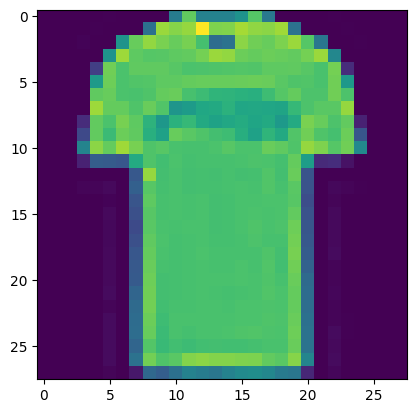

In [42]:
plt.figure()
plt.imshow(img)
plt.show()

In [43]:
print(predictions)
print("predicted label:", classes[np.argmax(predictions)])

[3.8974921703338623, 1.1893694400787354, 1.4680763483047485, 2.5411083698272705, 1.597705364227295, -3.148664712905884, 2.2885019779205322, -4.551593780517578, -0.8835963606834412, -2.8413894176483154]
predicted label: T-shirt/top


### 784 columns of float

In [44]:
df = spark.read.parquet("fashion_mnist_784")
len(df.columns)

784

In [45]:
%%time
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 897 ms, sys: 188 ms, total: 1.09 s
Wall time: 8.86 s


In [46]:
%%time
preds = df.withColumn("preds", mnist(array(*df.columns))).collect()

CPU times: user 548 ms, sys: 162 ms, total: 710 ms
Wall time: 3.06 s


### Check predictions

In [47]:
preds = df.withColumn("preds", mnist(array(*df.columns))).limit(10).toPandas()

In [48]:
sample = preds.iloc[0]
predictions = sample.preds
img = sample.drop('preds').to_numpy(dtype=float)

In [49]:
import matplotlib.pyplot as plt
import numpy as np

In [50]:
img = np.array(img).reshape(28,28)

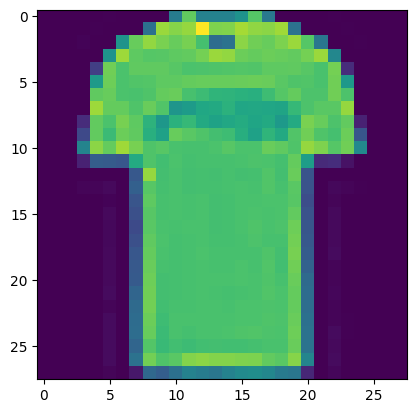

In [51]:
plt.figure()
plt.imshow(img)
plt.show()

In [52]:
print(predictions)
print("predicted label:", classes[np.argmax(predictions)])

[ 3.8974922   1.1893697   1.4680763   2.5411086   1.5977054  -3.1486647
  2.2885017  -4.5515933  -0.88359624 -2.8413894 ]
predicted label: T-shirt/top


### Using Triton Inference Server

Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [53]:
import numpy as np

from functools import partial
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col, array
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [54]:
%%bash
# copy model to expected layout for Triton
rm -rf models
mkdir -p models/fashion_mnist/1
cp model.pt models/fashion_mnist/1/model.pt

# add config.pbtxt
cp models_config/fashion_mnist/config.pbtxt models/fashion_mnist/config.pbtxt

#### Start Triton Server on each executor

In [55]:
num_executors = 1
triton_models_dir = "{}/models".format(os.getcwd())
nodeRDD = sc.parallelize(list(range(num_executors)), num_executors)

def start_triton(it):
    import docker
    import time
    import tritonclient.grpc as grpcclient
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    if containers:
        print(">>>> containers: {}".format([c.short_id for c in containers]))
    else:
        container=client.containers.run(
            "nvcr.io/nvidia/tritonserver:24.08-py3", "tritonserver --model-repository=/models",
            detach=True,
            device_requests=[docker.types.DeviceRequest(device_ids=["0"], capabilities=[['gpu']])],
            name="spark-triton",
            network_mode="host",
            remove=True,
            shm_size="64M",
            volumes={triton_models_dir: {"bind": "/models", "mode": "ro"}}
        )
        print(">>>> starting triton: {}".format(container.short_id))

        # wait for triton to be running
        time.sleep(15)
        client = grpcclient.InferenceServerClient("localhost:8001")
        ready = False
        while not ready:
            try:
                ready = client.is_server_ready()
            except Exception as e:
                time.sleep(5)
            
    return [True]

nodeRDD.barrier().mapPartitions(start_triton).collect()

>>>> starting triton: a169f4e8d17a                                  (0 + 1) / 1]


[True]

#### Run inference

In [56]:
df = spark.read.parquet("fashion_mnist_1")
len(df.columns)

1

In [57]:
df.schema

StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [58]:
def triton_fn(triton_uri, model_name):
    import numpy as np
    import tritonclient.grpc as grpcclient
    
    np_types = {
      "BOOL": np.dtype(np.bool_),
      "INT8": np.dtype(np.int8),
      "INT16": np.dtype(np.int16),
      "INT32": np.dtype(np.int32),
      "INT64": np.dtype(np.int64),
      "FP16": np.dtype(np.float16),
      "FP32": np.dtype(np.float32),
      "FP64": np.dtype(np.float64),
      "FP64": np.dtype(np.double),
      "BYTES": np.dtype(object)
    }

    client = grpcclient.InferenceServerClient(triton_uri)
    model_meta = client.get_model_metadata(model_name)
    
    def predict(inputs):
        if isinstance(inputs, np.ndarray):
            # single ndarray input
            request = [grpcclient.InferInput(model_meta.inputs[0].name, inputs.shape, model_meta.inputs[0].datatype)]
            request[0].set_data_from_numpy(inputs.astype(np_types[model_meta.inputs[0].datatype]))
        else:
            # dict of multiple ndarray inputs
            request = [grpcclient.InferInput(i.name, inputs[i.name].shape, i.datatype) for i in model_meta.inputs]
            for i in request:
                i.set_data_from_numpy(inputs[i.name()].astype(np_types[i.datatype()]))
        
        response = client.infer(model_name, inputs=request)
        
        if len(model_meta.outputs) > 1:
            # return dictionary of numpy arrays
            return {o.name: response.as_numpy(o.name) for o in model_meta.outputs}
        else:
            # return single numpy array
            return response.as_numpy(model_meta.outputs[0].name)
        
    return predict

In [59]:
mnist = predict_batch_udf(partial(triton_fn, triton_uri="localhost:8001", model_name="fashion_mnist"),
                          input_tensor_shapes=[[784]],
                          return_type=ArrayType(FloatType()),
                          batch_size=1024)

In [60]:
%%time
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 640 ms, sys: 85.5 ms, total: 726 ms
Wall time: 2.49 s


In [61]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 461 ms, sys: 116 ms, total: 577 ms
Wall time: 1.38 s


In [62]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 784 ms, sys: 108 ms, total: 892 ms
Wall time: 1.65 s


Predicted label: T-shirt/top


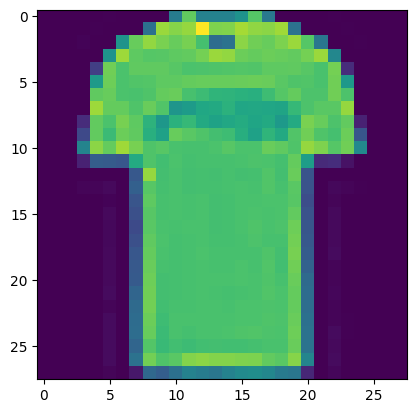

In [63]:
# Sample prediction
sample = preds[0]
predictions = sample.preds
img = sample.data

img = np.array(img).reshape(28,28)
plt.figure()
plt.imshow(img)

print("Predicted label:", classes[np.argmax(predictions)])

#### Stop Triton Server on each executor

In [64]:
def stop_triton(it):
    import docker
    import time
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    print(">>>> stopping containers: {}".format([c.short_id for c in containers]))
    if containers:
        container=containers[0]
        container.stop(timeout=120)

    return [True]

nodeRDD.barrier().mapPartitions(stop_triton).collect()

>>>> stopping containers: ['a169f4e8d17a']


[True]

In [65]:
spark.stop()